In [ ]:
# Chase Abram
# IO 2 2021 with Hortacsu

In [239]:
using CSV
using DataFrames
using ForwardDiff
using LinearAlgebra
using Optim

using Random, Distributions
using Statistics
# using Pkg
# Pkg.add("StatsPlots")
using StatsPlots

using Plots

In [290]:
# Section 1.3

# Compute the implied best-response probabilities
function BR_p(p, x, alpha, delta)
    if length(p) == 2
        return exp.(alpha .* x .- delta .* reverse(p) .- maximum(alpha .* x .- delta .* reverse(p)))./(exp(-maximum(alpha .* x .- delta .* reverse(p))) .+ exp.(alpha .*x .- delta .* reverse(p) .- maximum(alpha .* x .- delta .* reverse(p))))
    else
        return exp.(alpha .* x .- delta .* p .- maximum(alpha .* x .- delta .* p))./(exp(-maximum(alpha .* x .- delta .* p)) .+ exp.(alpha .*x .- delta .* p .- maximum(alpha .* x .- delta .* p)))
    end
end

# Jacobian of BR wrt p
function BR_p_jac(p, x, alpha, delta)
    if length(p) == 2
        return [0 -delta*exp.(alpha .* x .- delta .* p[2])./((1 .+ exp.(alpha .*x .- delta .* p[2]))^2);
            -delta*exp.(alpha .* x .- delta .* p[1])./((1 .+ exp.(alpha .*x .- delta .* p[1]))^2) 0]
    else
        return -delta*exp.(alpha .* x .- delta .* p[1])./((1 .+ exp.(alpha .*x .- delta .* p[1]))^2)
    end
end

# br_test(z) = BR_p(z, 2, 3, 6)

# println("BRj: ", BR_p_jac([0.7, 0.6], 2, 3, 6))
# println("AD: ", ForwardDiff.jacobian(br_test, [0.7, 0.6]))

# Finds local FP by Newton-Kantorovich
function fp_logit_nk(x, alpha, delta, p_init = [0.5], maxiter = 1000, tol = 1e-14)
    
    # Fix parameters
#     f(z) = BR_p(z,x,alpha,delta) - z
    
    # Initialize
    it = 0
    diff = Inf
    
    p = p_init
    pnew = zeros(length(p_init))
    
    # Find fixed point
    while it < maxiter && diff > tol
#         println("AD: ", ForwardDiff.jacobian(f, p))
#         pnew = p - ForwardDiff.jacobian(f, p) \ (f(p))
        
        # NK step
        pnew = p .- (BR_p_jac(p, x, alpha, delta) - I) \ (BR_p(p,x,alpha,delta) - p)
        
        # Update
        diff = maximum(abs.(pnew - p))
        it += 1
        p = pnew
    end
    
    if it == maxiter
#         println("max iterations in nk, diff = ", diff)
    end
    
    # Last step guarantee p in [0,1] and sum to 1
    p = BR_p(p,x,alpha,delta)
    
#     println("Exited NK") 
#     println("it: ", it, ", diff: ", diff)
#     println("p: ", p)
    
    # If symmetric, just return value
    if length(p) == 1
        return p[1]
    else
        return p
    end
    
end

# Find all the fixed points
function all_fp_logit_nk(x, theta::AbstractVector{T}, grid_size = 10, maxiter = 10000, tol = 1e-14) where T
    
#     grid = LinRange(0,1,grid_size)
#     gridi = [0.1,0.9]
#     gridj
    
    # Grid of starting points
    grid_init = [[0.5, 0.5], [1, 0], [0, 1]]
    
    # Store fixed points
    fps = []
    
    # Try different starting points
    for g in grid_init
        
        # Potential new fp
        add_f = fp_logit_nk(x, theta[1], theta[2], false, g, maxiter, tol)
        
        # Check if illegal addition
        illegal_add = isnan(add_f[1]) || isnan(add_f[2]) #|| add_f[1] > 1-1e-3 || add_f[1] < 1e-3 || add_f[2] > 1-1e-3 || add_f[2] < 1e-3

        # Check if (rough) duplicate or illegal
        add = true
        for f in fps
            if maximum(abs.(f - add_f)) < 1e-4 || illegal_add
                add = false
            end
        end
        
        # Add to list
        if add
            push!(fps, add_f)
        end
    end
    
    # Remove duplicates (should be done above already)
    fps = unique(fps)
    
    # Sort lexicographically
    sort!(fps, rev = true)
    
    # Turn into matrix
    fps_mat = zeros(T, length(fps), 2)
    for i in 1:size(fps_mat,1)
        fps_mat[i,:] = fps[i]
    end
    
    return fps_mat
end



all_fp_logit_nk (generic function with 4 methods)

In [296]:
# Test Kitchen

fp_logit_nk(2, 3.0, 6.0, [0.9, 0.1])

# cat(all_fp_logit_nk(1, [3.0, 6.0]), all_fp_logit_nk(2, [3.0, 6.0]), dims=3)
all_fp_logit_nk(2, [3.0, 6.0])

# for a in LinRange(4.5,5,100)
#     println("a: ", a)
#     for d in LinRange(8,10,100)
# #         println("a: ", a, ", d: ", d)
# #         all_fp_logit_nk(1, [a, d])
#         all_fp_logit_nk(2, [a, d])
#     end
# end


3×2 Array{Float64,2}:
 0.849318  0.71179
 0.784577  0.784577
 0.71179   0.849318

In [300]:
# Parameters
# alpha = 3
# delta = 6
# T = 1000
# S = 1

# # Generate data
# Random.seed!(1234)
# # Errors
# F = Logistic()
# ep = rand(F, S, T, 2)
# # Covariates
# x = (rand(S, T) .> 1/2) .+ 1

# # Initialize BR probs
# p = zeros(S,T)
# # p = Array{Array{Float64}}(undef, S, T)
# for s in 1:S
#     for t in 1:T
#         p[s,t] = fp_logit_nk(x[s,t], alpha, delta, true)
#     end
# end
# # Find implied entry decisions
# y = zeros(S,T,2)
# y = (alpha .* x .- delta.*p .+ ep) .> 0


# fp_logit_nk.(x, 3, 6, true)

# Log-likelihood (a la Siam (2006))
function siam_log_lik(theta, x, y)
    return sum(y .* log.(fp_logit_nk.(x, theta[1], theta[2], true)) .+ (1 .- y) .* log.(1 .- fp_logit_nk.(x, theta[1], theta[2], true)))
end


# Run Monte-Carlo with symmetric eq. ass.
function sym_MC(alpha, delta, S, T, seed)
    
    # Set seed (for replicability)
    Random.seed!(seed)
    
    # Errors
    F = Logistic()
    ep = rand(F, S, T, 2)
    
    # Covariates
    x = (rand(S, T) .> 1/2) .+ 1
    
    # Probabilities
    p = zeros(S,T)
    for s in 1:S
        for t in 1:T
            p[s,t] = fp_logit_nk(x[s,t], alpha, delta, true)
        end
    end
    
    # Implied entries
    y = zeros(S,T,2)
    y = (alpha .* x .- delta.*p .+ ep) .> 0
    
    # Initialize
    pars = zeros(S,2)
    pars_sd = zeros(S,2)
    
    # Get implied parameter estimates for each simulation
    for s in 1:S
        # Create function of parameters only
        sll(t) = -siam_log_lik(t, x[s,:], y[s,:,:])
        
        # Max log-lik
        pars[s,:] = optimize(sll, [1.0,1.0], BFGS(), Optim.Options(show_trace = true); autodiff = :forward).minimizer
        
        pars_sd[s,:] = sqrt.(abs.(diag(ForwardDiff.hessian(sll, pars[s,:]) \ I)))
        
        # Status updates
        println("Simulation ", s, " complete:")
        println("    par: ", pars[s,:])
    end
    
    return pars, pars_sd
end

# alpha = 3, delta = 6, S = 50, T = 1000, seed = 1234
sim_pars, sim_pars_sd = sym_MC(3, 6, 50, 1000, 1234)

Iter     Function value   Gradient norm 
     0     1.220027e+03     3.303239e+01
 * time: 8.0108642578125e-5
     1     1.218948e+03     1.429400e+01
 * time: 0.007498979568481445
     2     1.215338e+03     2.411327e+01
 * time: 0.017515182495117188
     3     1.210173e+03     1.223891e+00
 * time: 0.027489185333251953
     4     1.209725e+03     7.546933e+00
 * time: 0.034551143646240234
     5     1.209408e+03     1.230647e+01
 * time: 0.043734073638916016
     6     1.209128e+03     4.707503e+00
 * time: 0.05437803268432617
     7     1.209085e+03     1.187031e-01
 * time: 0.06116604804992676
     8     1.209085e+03     1.666364e-02
 * time: 0.06796813011169434
     9     1.209085e+03     1.780696e-05
 * time: 0.07740116119384766
    10     1.209085e+03     5.658302e-09
 * time: 0.0844871997833252
Simulation 1 complete:
    par: [2.249902367242151, 4.049688738227378]
Iter     Function value   Gradient norm 
     0     1.209323e+03     2.328724e+01
 * time: 5.888938903808594e-5
   

     1     1.248696e+03     9.418717e+00
 * time: 0.010490179061889648
     2     1.244315e+03     9.464362e+00
 * time: 0.23484301567077637
     3     1.231172e+03     8.357139e+00
 * time: 0.24399113655090332
     4     1.230928e+03     1.997011e-01
 * time: 0.25475120544433594
     5     1.230926e+03     6.917267e-01
 * time: 0.2648580074310303
     6     1.230924e+03     2.580384e-02
 * time: 0.2763051986694336
     7     1.230924e+03     1.739725e-04
 * time: 0.28359198570251465
     8     1.230924e+03     9.186648e-08
 * time: 0.2913320064544678
     9     1.230924e+03     9.814372e-13
 * time: 0.3113090991973877
Simulation 11 complete:
    par: [3.0703936417420272, 6.390169796984405]
Iter     Function value   Gradient norm 
     0     1.259550e+03     9.768805e+01
 * time: 7.104873657226562e-5
     1     1.251557e+03     1.035593e+01
 * time: 0.009954214096069336
     2     1.246907e+03     9.344965e+00
 * time: 0.24334216117858887
     3     1.233658e+03     8.468271e+00
 * tim

     1     1.247562e+03     7.118773e+00
 * time: 0.015170097351074219
     2     1.245443e+03     3.723414e+01
 * time: 0.024024009704589844
     3     1.239529e+03     1.157769e+01
 * time: 0.03751206398010254
     4     1.238709e+03     1.267872e+00
 * time: 0.044801950454711914
     5     1.238482e+03     6.205935e+00
 * time: 0.051772117614746094
     6     1.238348e+03     3.415662e+00
 * time: 0.06395411491394043
     7     1.238329e+03     1.164008e-02
 * time: 0.07002711296081543
     8     1.238329e+03     1.764252e-04
 * time: 0.07613110542297363
     9     1.238329e+03     2.457748e-08
 * time: 0.08480405807495117
    10     1.238329e+03     6.483702e-14
 * time: 0.09331893920898438
Simulation 21 complete:
    par: [2.1342911378076876, 4.085191243537306]
Iter     Function value   Gradient norm 
     0     1.228822e+03     6.140270e+01
 * time: 8.20159912109375e-5
     1     1.226902e+03     5.790881e+01
 * time: 0.010504961013793945
     2     1.214882e+03     3.581819e+01


Simulation 30 complete:
    par: [4.095355248933945, 8.452889027031983]
Iter     Function value   Gradient norm 
     0     1.214664e+03     2.975924e+01
 * time: 9.107589721679688e-5
     1     1.213626e+03     1.877428e+01
 * time: 0.013801097869873047
     2     1.208429e+03     1.223102e+01
 * time: 0.23790192604064941
     3     1.197134e+03     1.303170e+01
 * time: 0.25182604789733887
     4     1.196610e+03     4.339609e-01
 * time: 0.26438188552856445
     5     1.196608e+03     4.019798e-01
 * time: 0.280134916305542
     6     1.196607e+03     1.030147e-02
 * time: 0.29263806343078613
     7     1.196607e+03     2.622288e-05
 * time: 0.314129114151001
     8     1.196607e+03     5.130661e-09
 * time: 0.325855016708374
Simulation 31 complete:
    par: [3.0190631881451275, 5.842058884219261]
Iter     Function value   Gradient norm 
     0     1.225459e+03     3.214704e+01
 * time: 5.602836608886719e-5
     1     1.224524e+03     8.439031e+00
 * time: 0.025169849395751953
     

     3     1.214651e+03     1.691737e+01
 * time: 0.2392411231994629
     4     1.213829e+03     1.084316e+00
 * time: 0.2486710548400879
     5     1.213825e+03     1.663051e-01
 * time: 0.2560100555419922
     6     1.213824e+03     1.708906e-02
 * time: 0.27100110054016113
     7     1.213824e+03     7.967973e-06
 * time: 0.2783210277557373
     8     1.213824e+03     4.844239e-09
 * time: 0.28757405281066895
Simulation 40 complete:
    par: [2.8662573010663754, 5.567550008442992]
Iter     Function value   Gradient norm 
     0     1.233217e+03     4.915471e+01
 * time: 7.390975952148438e-5
     1     1.231313e+03     3.261595e+01
 * time: 0.009820938110351562
     2     1.227474e+03     2.584743e+01
 * time: 0.25380492210388184
     3     1.216401e+03     1.740073e+01
 * time: 0.26381492614746094
     4     1.215529e+03     1.136280e+00
 * time: 0.2738759517669678
     5     1.215523e+03     3.184736e-01
 * time: 0.28147387504577637
     6     1.215522e+03     2.675599e-02
 * time:

     7     1.244336e+03     7.843434e-03
 * time: 0.09409904479980469
     8     1.244336e+03     3.146900e-03
 * time: 0.10143804550170898
     9     1.244336e+03     1.652565e-08
 * time: 0.11122703552246094
    10     1.244336e+03     8.276047e-12
 * time: 0.12170886993408203
Simulation 50 complete:
    par: [2.6206679091162237, 5.371761541045112]


([2.249902367242151 4.049688738227378; 3.140752909366451 6.062736965174698; … ; 3.179506836678428 6.526099958211582; 2.6206679091162237 5.371761541045112], [0.45226501983343587 1.0641265733372605; 0.6887359523888057 1.6185369757376733; … ; 0.7457730203234544 1.8108396103887094; 0.5929363684809739 1.463438380924573])

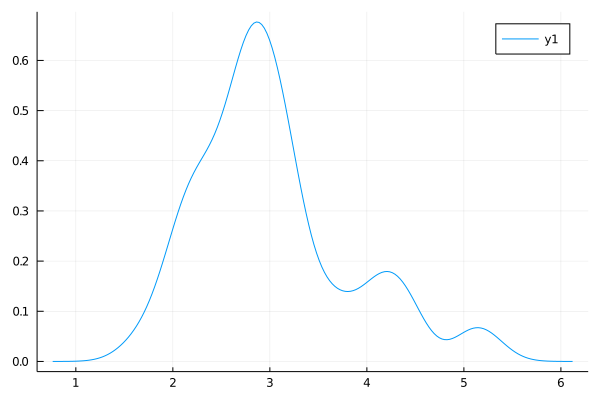

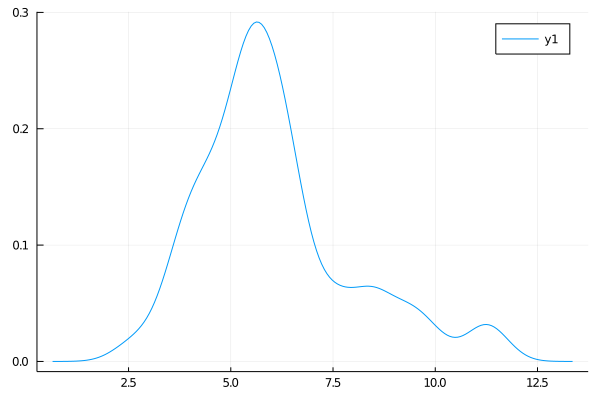

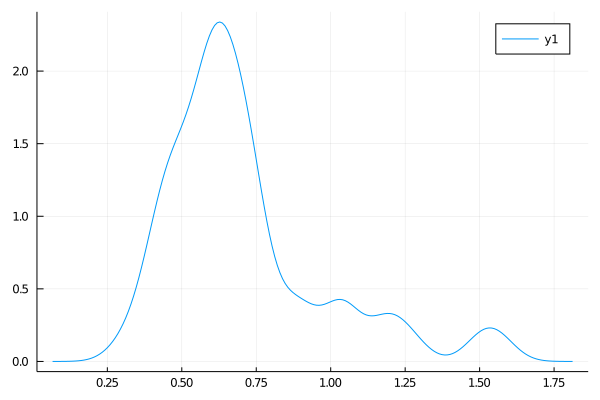

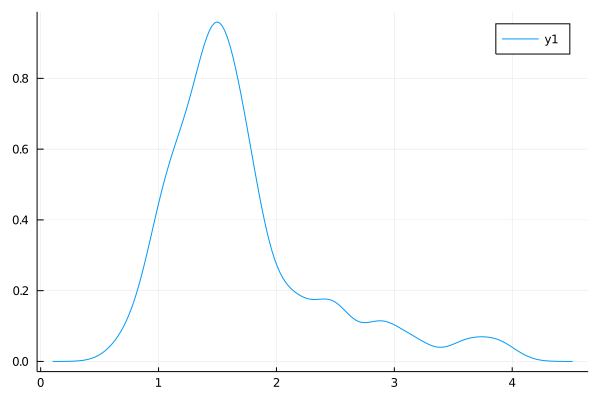

alpha: mean = 3.020862413265163 var = 0.62226850250882
delta: mean = 6.069350150688116 var = 3.6206615358956102
alpha_sd: mean = 0.7082745227560125 var = 0.07391940757650911
delta_sd: mean = 1.708240580080603 var = 0.4472021177607279


In [301]:
# Plots of empirical density for each parameter
d_alpha = density(sim_pars[:,1])
display(d_alpha)
d_delta = density(sim_pars[:,2])
display(d_delta)
println("alpha: mean = ", mean(sim_pars[:,1]), " var = ", var(sim_pars[:,1]))
println("delta: mean = ", mean(sim_pars[:,2]), " var = ", var(sim_pars[:,2]))

d_alpha_sd = density(sim_pars_sd[:,1])
display(d_alpha_sd)
d_delta_sd = density(sim_pars_sd[:,2])
display(d_delta_sd)
println("alpha_sd: mean = ", mean(sim_pars_sd[:,1]), " var = ", var(sim_pars_sd[:,1]))
println("delta_sd: mean = ", mean(sim_pars_sd[:,2]), " var = ", var(sim_pars_sd[:,2]))



In [330]:
# Simulate data for Q4

# True eq probs
function eq_probs(K)
    return exp.(LinRange(1,K,K)./2)./ sum(exp.(LinRange(1,K,K)./2))
end

# Individual terms in mixture log-likelihood
function mll_term(x, y, ep, bnp)
    
    # Check if term in log ever goes negative
    if (ep[x]' * (bnp[x][:,1].^y[1].*(1 .- bnp[x][:,1]).^(1 .- y[1]).*bnp[x][:,2].^y[2].*(1 .- bnp[x][:,2]).^(1 .- y[2])))[1] < 0
        println("neg in mll_term")
        println("    x: ", x)
        println("    y: ", y)
        println("    ep[x]: ", ep[x])
        println("    bnp[x]: ", bnp[x])
        return -Inf
    end
    
    return log.(ep[x]' * (bnp[x][:,1].^y[1].*(1 .- bnp[x][:,1]).^(1 .- y[1]).*bnp[x][:,2].^y[2].*(1 .- bnp[x][:,2]).^(1 .- y[2])))
end


# Log-likelihood (mixture)
function mix_log_lik(theta::AbstractVector{T}, x, y, ep_given::AbstractVector{T}) where T
    
    # Build bn_probs for each x
    bnp = [all_fp_logit_nk(1, theta), all_fp_logit_nk(2, theta)]
    
    # Check for negative BN probs
    for i in 1:length(bnp)
        if minimum(bnp[i]) < 0
            println("neg bnp: ", bnp)
            println("    at theta: ", theta)
        end
    end
    
    # Store eqs
    ep = []
    
    # x = 1
    if size(bnp[1],1) == 1
        # all weight on one eq
        push!(ep, [1])
    elseif size(bnp[1],1) == 3
        # use given weight split
        push!(ep,ep_given)
    else
        # finding a wrong number of eq (should not happen)
        println("weird bnp detected, x = 1, eq: ", size(bnp[1],1))
        push!(ep, eq_probs(size(bnp[1],1)))
    end
    
    # x = 2
    if size(bnp[2],1) == 1
        # all weight on one eq
        push!(ep, [1])
    elseif size(bnp[2],1) == 3
        # use given weight split
        push!(ep, ep_given)
    else
        # finding a wrong number of eq (should not happen)
        println("weird bnp detected, x = 2, eqs: ", size(bnp[2],1))
        push!(ep, eq_probs(size(bnp[2],1)))
    end
    
    # Check for negative eq probs
    for i in 1:length(ep)
        if minimum(ep[i]) < 0
            println("neg ep: ", ep)
            println("    at theta: ", theta)
        end
    end
    
    # Check if weird number of eqs
    if length(ep) != 2
        println("strange ep")
    end
    
    return sum([mll_term(x[i], y[i,:], ep, bnp) for i in 1:length(x)])
end



# Run Monte-Carlo with possible asymmetries per Q4
function asym_MC(theta, S, T, seed)
    
    # Set seed (for replicability)
    Random.seed!(seed)
    
    # Errors
    F = Logistic()
    ep = rand(F, S, T, 2)
    
    # Covariates
    x = (rand(S, T) .> 1/2) .+ 1
    
    # Store eqs. for each x type
    eqs = zeros(3,2,2)
    eqs[:,:,1] = all_fp_logit_nk(1, theta)
    eqs[:,:,2] = all_fp_logit_nk(2, theta)
    
    # Number of eqs (use that 3 in both cases)
    K = size(eqs,1)
    println("K: ", K)
    
    # Generate cutoff for choosing eq type
    eqprobs = LinRange(1,K,K)
    eqprobs = exp.(eqprobs./2)
    eqprobs = eqprobs./ sum(eqprobs)
#     println("eqprobs: ", eqprobs)
#     eq_cuts = cumsum(eqprobs)
#     sort!(eq_cuts)
#     println("eq_cuts: ", eq_cuts)
    
    # pmf over eq selection
    d = Categorical(eqprobs)
    
    # Initialize
    eq_draw = 0
#     eq = 0
    
#     eq_counts = zeros(K)
    
    # Probabilities
    p = zeros(S,T,2)
    for s in 1:S
        for t in 1:T
            # Draw eq selection
            draw = rand(d)
            
#             eq_counts[draw] += 1
            
            # add to probs list
            p[s,t,:] = eqs[draw,:,x[s,t]]
        end
    end
    
#     println("eq_counts check: ", sum(eq_counts))
#     println("eq_counts: ", eq_counts)
#     println("eq_dist: ", eq_counts ./sum(eq_counts))
    
    # Implied entries
    y = zeros(S,T,2)
    y = (theta[1] .* x .- theta[2].*p .+ ep) .> 0
    
    pars = zeros(S,5)
    pars_sd = zeros(S,5)
    
    # Get implied parameter estimates for each simulation
    for s in 1:S
        # Create function of parameters only
        mll(t) = -mix_log_lik(t[1:2], x[s,:], y[s,:,:], exp.(t[3:5])./sum(exp.(t[3:5])))
        
        # Max log-lik
        pars[s,:] = optimize(mll, [1.0, 1.0, 1.0, 1.0, 1.0], BFGS(), Optim.Options(show_trace = true, iterations = 50); autodiff = :forward).minimizer
        
        pars_sd[s,:] = sqrt.(abs.(diag(ForwardDiff.hessian(mll, pars[s,:]) \ I)))
        
        # Status updates
        println("Simulation ", s, " complete:")
        println("    par: ", pars[s,:])
    end
    
    return pars, pars_sd
end

asim_pars, asim_pars_sd = asym_MC([3.0, 6.0], 50, 1000, 12345)


K: 3
Iter     Function value   Gradient norm 
     0     1.221963e+03     3.529329e+01
 * time: 9.298324584960938e-5
     1     1.220632e+03     2.792816e+01
 * time: 0.03832101821899414
     2     1.148096e+03     1.011973e+02
 * time: 0.48325109481811523
     3     1.119326e+03     8.735557e+01
 * time: 1.4351630210876465
     4     1.108764e+03     2.975619e+01
 * time: 1.5457398891448975
     5     1.100445e+03     4.435178e+01
 * time: 1.583820104598999
     6     1.090541e+03     2.484881e+01
 * time: 1.6477560997009277
     7     1.086879e+03     4.451022e+01
 * time: 1.6956839561462402
     8     1.085168e+03     1.698636e+01
 * time: 1.7540769577026367
     9     1.082844e+03     1.922153e+01
 * time: 1.8446600437164307
    10     1.082410e+03     1.889117e+01
 * time: 1.9117560386657715
    11     1.079153e+03     8.077431e+01
 * time: 1.940321922302246
    12     1.078848e+03     6.200733e+00
 * time: 2.0393810272216797
    13     1.078231e+03     8.496392e+00
 * time: 2.074

    14     1.115000e+03     5.329785e+00
 * time: 1.572005033493042
    15     1.114859e+03     6.496246e+00
 * time: 1.6275629997253418
    16     1.114787e+03     5.593756e-01
 * time: 1.6710898876190186
    17     1.114772e+03     3.015761e-01
 * time: 1.7060208320617676
    18     1.114771e+03     3.811174e-02
 * time: 1.7509818077087402
    19     1.114771e+03     1.491898e-03
 * time: 1.7927978038787842
    20     1.114771e+03     7.171892e-06
 * time: 1.822253942489624
    21     1.114771e+03     3.686276e-07
 * time: 1.8598759174346924
    22     1.114771e+03     2.715786e-10
 * time: 2.059443950653076
Simulation 5 complete:
    par: [3.0774053090064517, 6.195138475985546, 1.5225419111645009, 0.8752952743673312, 0.6021628144731609]
Iter     Function value   Gradient norm 
     0     1.194228e+03     1.643190e+01
 * time: 9.489059448242188e-5
     1     1.193894e+03     1.140831e+01
 * time: 0.07872200012207031
     2     1.133726e+03     7.207856e+01
 * time: 0.1198890209197998

    11     1.142721e+03     3.348752e+00
 * time: 0.8185000419616699
    12     1.142536e+03     7.529149e+00
 * time: 0.8483810424804688
    13     1.142502e+03     2.865703e-01
 * time: 0.8723640441894531
    14     1.142501e+03     3.224040e-01
 * time: 0.9880590438842773
    15     1.142500e+03     2.569186e-02
 * time: 1.0862128734588623
    16     1.142500e+03     2.007986e-04
 * time: 1.2151248455047607
    17     1.142500e+03     1.876463e-06
 * time: 1.3186109066009521
    18     1.142500e+03     1.329287e-07
 * time: 1.4224929809570312
    19     1.142500e+03     3.659939e-11
 * time: 1.5366010665893555
Simulation 9 complete:
    par: [3.0572984624903503, 6.081843688085263, 1.3483451479595827, 1.2278454071511467, 0.4238094448880907]
Iter     Function value   Gradient norm 
     0     1.251727e+03     8.292290e+01
 * time: 0.00020599365234375
     1     1.246089e+03     7.680322e+00
 * time: 0.07486176490783691
     2     1.166654e+03     5.845974e+01
 * time: 0.11921596527099

    12     1.128152e+03     5.719334e-01
 * time: 0.5773611068725586
    13     1.128151e+03     3.966422e-02
 * time: 0.622122049331665
    14     1.128151e+03     2.273126e-03
 * time: 0.6584129333496094
    15     1.128151e+03     5.543040e-05
 * time: 0.6919760704040527
    16     1.128151e+03     1.003656e-06
 * time: 0.7280139923095703
    17     1.128151e+03     2.834986e-10
 * time: 0.776170015335083
Simulation 14 complete:
    par: [2.9532672219972125, 5.9662366178589075, 1.547570018395273, 0.7223384981938769, 0.7300914834152472]
Iter     Function value   Gradient norm 
     0     1.249498e+03     9.016816e+01
 * time: 8.893013000488281e-5
     1     1.242739e+03     9.734545e+00
 * time: 0.05640292167663574
     2     1.188886e+03     8.222027e+01
 * time: 0.07973194122314453
     3     1.175907e+03     6.220080e+01
 * time: 0.18008208274841309
weird bnp detected, x = 2, eqs: 2
     4     1.164452e+03     1.507928e+01
 * time: 0.394258975982666
     5     1.155467e+03     1.7

     9     1.144617e+03     4.431723e+00
 * time: 1.3942627906799316
    10     1.141084e+03     2.408279e+01
 * time: 1.4972519874572754
    11     1.140909e+03     2.791196e+01
 * time: 1.611717939376831
    12     1.139508e+03     4.725245e+01
 * time: 1.7240359783172607
    13     1.138497e+03     1.449626e+01
 * time: 1.8070437908172607
    14     1.138211e+03     1.634388e+01
 * time: 1.8764398097991943
    15     1.136605e+03     6.551283e+00
 * time: 1.9483399391174316
    16     1.136519e+03     3.241337e+00
 * time: 2.017960786819458
    17     1.136496e+03     1.901931e+00
 * time: 2.1159098148345947
    18     1.136486e+03     5.428726e-01
 * time: 2.180067777633667
    19     1.136458e+03     1.239538e+00
 * time: 2.305506944656372
    20     1.135740e+03     2.377610e+01
 * time: 2.571138858795166
    21     1.135388e+03     2.608073e+00
 * time: 3.081211805343628
    22     1.135381e+03     5.060439e-01
 * time: 3.227250814437866
    23     1.135380e+03     6.026370e-01


Simulation 23 complete:
    par: [2.7447391007986397, 5.609081611003293, 1.5380733760507355, 0.6317783023754642, 0.8301483215745936]
Iter     Function value   Gradient norm 
     0     1.217981e+03     4.445331e+01
 * time: 0.00010800361633300781
     1     1.216316e+03     2.749871e+01
 * time: 0.03378701210021973
     2     1.141883e+03     6.536354e+01
 * time: 0.05762600898742676
     3     1.135969e+03     7.648716e+01
 * time: 0.15205788612365723
     4     1.129028e+03     2.124294e+01
 * time: 0.5223300457000732
     5     1.119350e+03     3.272769e+01
 * time: 0.573767900466919
     6     1.116325e+03     1.270160e+01
 * time: 0.6305398941040039
     7     1.115505e+03     1.881071e+01
 * time: 0.6962249279022217
     8     1.114284e+03     8.878244e+00
 * time: 0.7597558498382568
     9     1.113855e+03     1.949443e+01
 * time: 0.8194549083709717
    10     1.112976e+03     5.542420e+00
 * time: 0.8648829460144043
    11     1.112906e+03     1.642926e+00
 * time: 0.888442039

    20     1.092664e+03     2.964300e-05
 * time: 2.6037580966949463
    21     1.092664e+03     3.317624e-07
 * time: 2.686037063598633
    22     1.092664e+03     4.051407e-10
 * time: 2.729572057723999
Simulation 27 complete:
    par: [3.1601638581809777, 6.24505135075554, 1.5053995988042006, 1.1946345495544317, 0.29996585164287115]
Iter     Function value   Gradient norm 
     0     1.222001e+03     4.568875e+01
 * time: 0.00010204315185546875
     1     1.220274e+03     3.570318e+01
 * time: 0.08292293548583984
     2     1.166309e+03     9.828992e+01
 * time: 0.1716599464416504
     3     1.144050e+03     8.947052e+01
 * time: 0.30190491676330566
     4     1.130998e+03     3.776945e+01
 * time: 0.9855289459228516
     5     1.122162e+03     3.775302e+01
 * time: 1.1075999736785889
     6     1.116650e+03     1.198329e+01
 * time: 1.3273229598999023
     7     1.114135e+03     4.026780e+01
 * time: 1.4544439315795898
     8     1.111064e+03     1.461424e+01
 * time: 1.52370405197

    34     1.118574e+03     7.184483e-02
 * time: 3.994354009628296
    35     1.118573e+03     5.468455e-02
 * time: 4.035759925842285
    36     1.118573e+03     4.053438e-02
 * time: 4.1062400341033936
    37     1.118573e+03     3.462143e-02
 * time: 4.168873071670532
    38     1.118573e+03     1.209885e-02
 * time: 4.2278220653533936
    39     1.118573e+03     1.380382e-02
 * time: 4.280405044555664
    40     1.118573e+03     4.171336e-03
 * time: 4.326195955276489
    41     1.118573e+03     5.009397e-03
 * time: 4.372741937637329
    42     1.118573e+03     1.510468e-03
 * time: 4.513306140899658
    43     1.118573e+03     1.803603e-03
 * time: 4.568587064743042
    44     1.118573e+03     5.598626e-04
 * time: 4.624998092651367
    45     1.118573e+03     6.596235e-04
 * time: 4.68681001663208
    46     1.118573e+03     2.065347e-04
 * time: 4.752568006515503
    47     1.118573e+03     2.426126e-04
 * time: 4.815410137176514
    48     1.118573e+03     7.556706e-05
 * tim

     1     1.238827e+03     6.305690e+01
 * time: 0.05841684341430664
     2     1.199658e+03     1.092150e+02
 * time: 0.09681105613708496
     3     1.168508e+03     7.854920e+01
 * time: 0.2944149971008301
     4     1.158806e+03     1.979583e+01
 * time: 0.7220199108123779
weird bnp detected, x = 1, eq: 2
     5     1.141035e+03     7.259533e+01
 * time: 0.9704439640045166
     6     1.132604e+03     6.135862e+01
 * time: 1.1248629093170166
     7     1.117579e+03     1.404395e+01
 * time: 1.315654993057251
     8     1.116118e+03     3.462868e+00
 * time: 1.3883309364318848
     9     1.116017e+03     1.667836e+00
 * time: 1.5042588710784912
    10     1.116011e+03     4.810804e-01
 * time: 1.570878028869629
    11     1.115893e+03     1.671268e+00
 * time: 1.8281450271606445
    12     1.115861e+03     2.514477e+00
 * time: 1.9192509651184082
    13     1.115809e+03     2.596184e+00
 * time: 2.0117850303649902
    14     1.115773e+03     2.224651e+00
 * time: 2.127748966217041
  

Simulation 38 complete:
    par: [3.5585887336657014, 6.967318723158433, 1.3824036996663036, 1.3832150557712861, 0.2343812445601035]
Iter     Function value   Gradient norm 
     0     1.242336e+03     6.739217e+01
 * time: 6.198883056640625e-5
     1     1.240243e+03     5.612032e+01
 * time: 0.03834700584411621
     2     1.157972e+03     7.512218e+01
 * time: 0.09351396560668945
     3     1.148545e+03     8.708709e+01
 * time: 0.28848695755004883
     4     1.139688e+03     3.800745e+01
 * time: 0.5588388442993164
     5     1.128369e+03     2.647174e+01
 * time: 0.592602014541626
     6     1.126859e+03     3.668766e+01
 * time: 0.7232449054718018
     7     1.123765e+03     1.531894e+01
 * time: 0.7588579654693604
     8     1.122306e+03     3.479314e+01
 * time: 0.804987907409668
     9     1.121303e+03     3.235912e+01
 * time: 0.8627328872680664
    10     1.120536e+03     2.728753e+01
 * time: 0.8851120471954346
    11     1.119238e+03     8.643718e+00
 * time: 0.931288003921

    10     1.130263e+03     3.273342e+01
 * time: 1.1466538906097412
    11     1.128392e+03     2.753919e+01
 * time: 1.1947450637817383
    12     1.125553e+03     2.219252e+01
 * time: 1.2300739288330078
    13     1.124821e+03     1.142718e+01
 * time: 1.2986409664154053
    14     1.124488e+03     4.019985e+00
 * time: 1.382446050643921
    15     1.124401e+03     1.924714e-01
 * time: 1.461333990097046
    16     1.124393e+03     6.846036e-01
 * time: 1.6993451118469238
    17     1.124326e+03     3.555669e+01
 * time: 1.7778949737548828
    18     1.124134e+03     6.729055e+00
 * time: 2.056739091873169
    19     1.124124e+03     2.710062e+00
 * time: 2.17130708694458
    20     1.124119e+03     1.325826e+00
 * time: 2.308621883392334
    21     1.124119e+03     1.292027e-02
 * time: 2.409588098526001
    22     1.124119e+03     7.877535e-02
 * time: 2.633913993835449
    23     1.124119e+03     7.766605e-04
 * time: 2.7006618976593018
    24     1.124119e+03     4.867741e-06
 

    24     1.115060e+03     8.341555e-01
 * time: 1.3740668296813965
    25     1.115059e+03     7.996969e-01
 * time: 1.4068949222564697
    26     1.115052e+03     3.560294e-01
 * time: 1.4477648735046387
    27     1.115051e+03     2.279767e-01
 * time: 1.4740350246429443
    28     1.115051e+03     1.330702e-01
 * time: 1.5256118774414062
    29     1.115050e+03     2.459600e-01
 * time: 1.5945899486541748
    30     1.115048e+03     2.820079e-01
 * time: 1.6575520038604736
    31     1.115047e+03     9.745795e-02
 * time: 1.6905288696289062
    32     1.115047e+03     1.088881e-01
 * time: 1.8662879467010498
    33     1.115046e+03     1.590562e-01
 * time: 1.9079058170318604
    34     1.115045e+03     2.076923e-01
 * time: 1.9565458297729492
    35     1.115045e+03     1.469078e-01
 * time: 1.9940969944000244
    36     1.115045e+03     5.820918e-02
 * time: 2.039362907409668
    37     1.115045e+03     9.332620e-02
 * time: 2.1253910064697266
    38     1.115044e+03     1.00218

     4     1.147643e+03     4.339326e+01
 * time: 0.5070700645446777
     5     1.136959e+03     2.438439e+01
 * time: 0.5806691646575928
     6     1.134703e+03     2.282257e+01
 * time: 0.6611261367797852
     7     1.133981e+03     2.217596e+01
 * time: 0.7099380493164062
     8     1.133093e+03     1.134360e+01
 * time: 0.7641580104827881
     9     1.132761e+03     2.059460e+00
 * time: 0.8596761226654053
    10     1.132708e+03     7.608603e-01
 * time: 0.9880070686340332
    11     1.132595e+03     6.633524e-01
 * time: 1.1100940704345703
    12     1.132539e+03     1.166408e+00
 * time: 1.1587979793548584
    13     1.132449e+03     1.482986e+00
 * time: 1.2507710456848145
    14     1.132404e+03     2.819850e+00
 * time: 1.3308370113372803
    15     1.132350e+03     2.079043e+00
 * time: 1.3754351139068604
    16     1.132303e+03     9.247083e-01
 * time: 1.476011037826538
    17     1.132289e+03     4.180214e-01
 * time: 1.530411958694458
    18     1.132286e+03     6.249180

([3.3604501160049276 6.5628100627405725 … 1.0933638567930404 0.3656213000470727; 3.3580950113822476 6.648314722099654 … 1.2773207850271584 0.4676458596910917; … ; 3.0120477501653458 6.035837772299743 … 1.212829111810795 0.3454596177705798; 2.9065203592446465 5.859622291590013 … 0.8675778121741277 0.5599491498270454], [0.2453260026642616 0.40572357870031844 … 2.9205384347424274e6 2.920538434742418e6; 0.29937586489353146 0.540243406455783 … 2.3726566406062096e6 2.3726566406062865e6; … ; 0.2080390358874975 0.33659852737141777 … 1.2076504330512402e6 1.207650433051301e6; 0.1904815128104605 0.2965721196226112 … 1.114156627681247e6 1.1141566276812912e6])

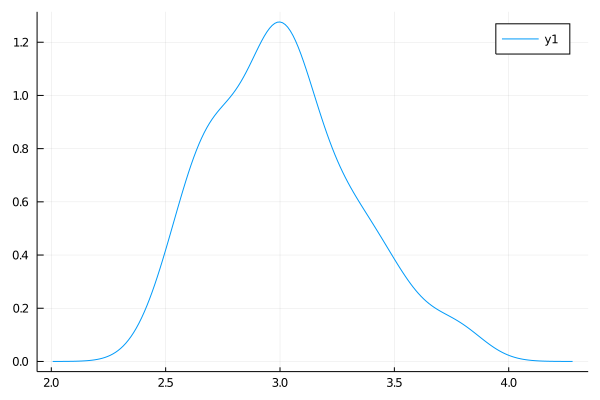

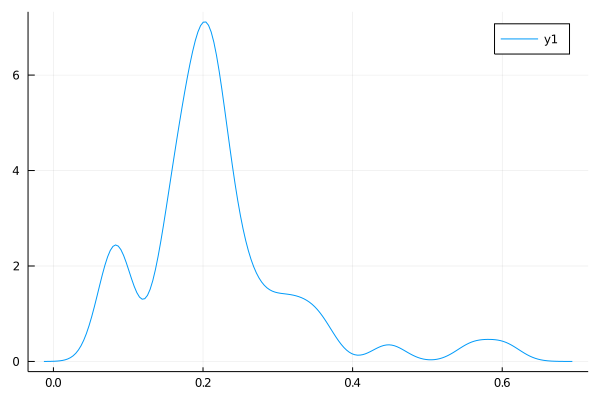

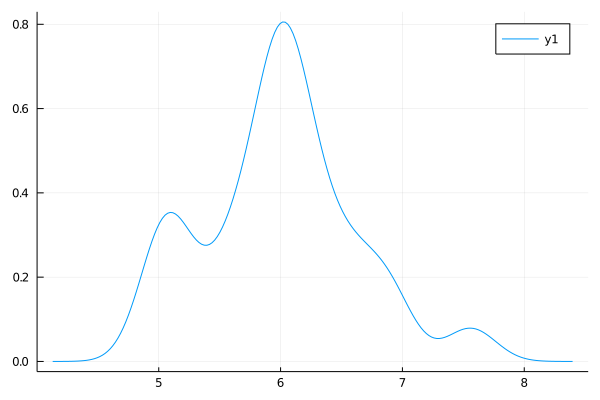

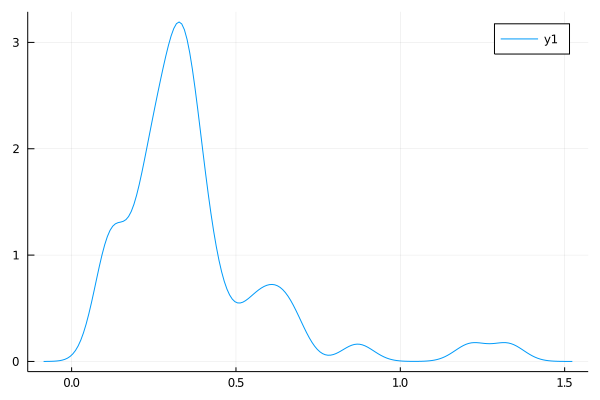

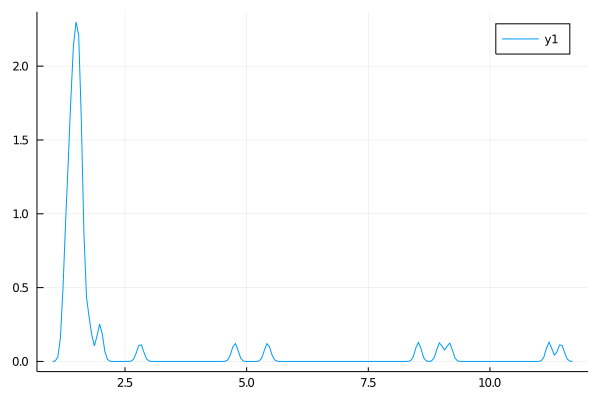

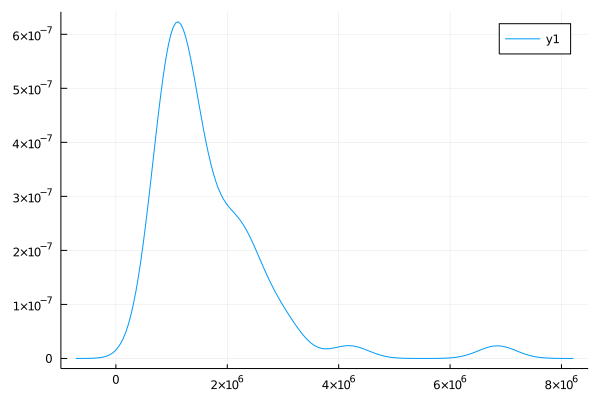

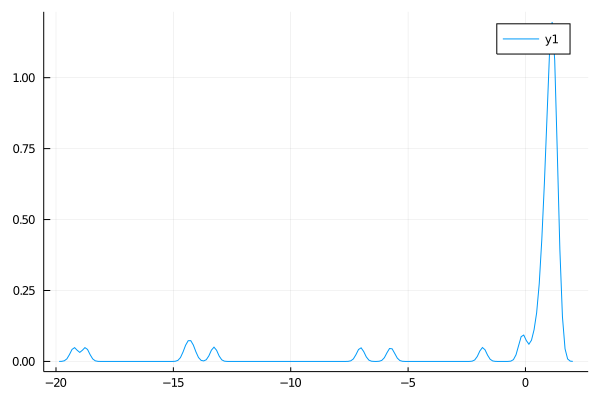

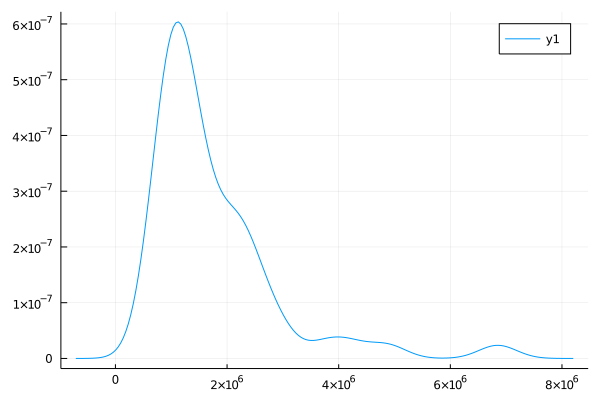

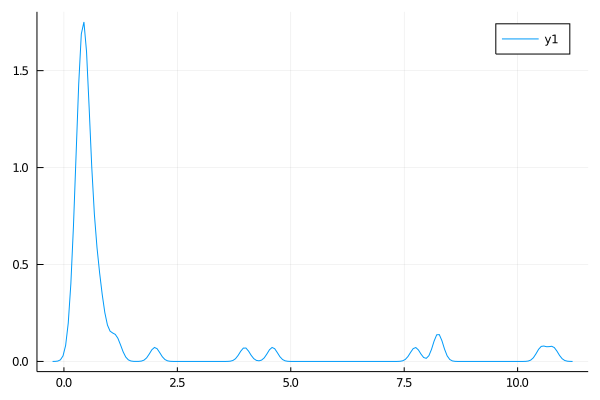

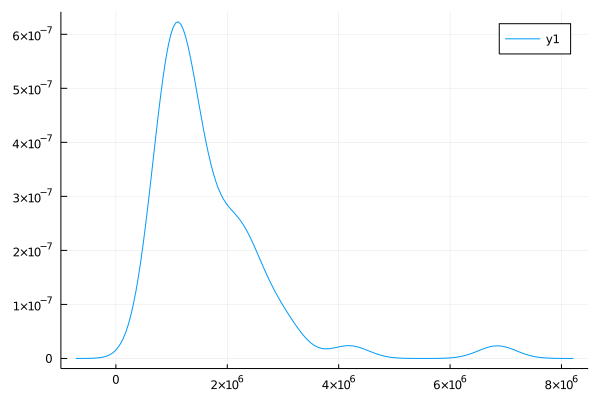

asim_pars[:,1]: mean = 3.015671378688667 var = 0.09498014961833563
asim_pars_sd[:,1]: mean = 0.22043193262898675 var = 0.011444747398286286
asim_pars[:,2]: mean = 5.996161133999907 var = 0.39140841340610427
asim_pars_sd[:,2]: mean = 0.37917224062594346 var = 0.06010502067636106
asim_pars[:,3]: mean = 2.50936385806246 var = 6.841254202998297
asim_pars_sd[:,3]: mean = 1.662599475488438e6 var = 1.1095006054874207e12
asim_pars[:,4]: mean = -1.0562951694653733 var = 28.22433963962544
asim_pars_sd[:,4]: mean = 1.751959606642214e6 var = 1.3432057494808406e12
asim_pars[:,5]: mean = 1.546931311403472 var = 7.28523504713104
asim_pars_sd[:,5]: mean = 1.6625994754884373e6 var = 1.1095006054874185e12
weights: [0.7090986796164226 0.020052135779040435 0.27084918460453694]


In [333]:
# Plots of empirical density for each parameter

for i in 1:size(asim_pars,2)
    ad_theta = density(asim_pars[:,i])
    display(ad_theta)
    println("asim_pars[:," , i,"]: mean = ", mean(asim_pars[:,i]), " var = ", var(asim_pars[:,i]))
    
    ad_theta_sd = density(asim_pars_sd[:,i])
    display(ad_theta_sd)
    println("asim_pars_sd[:," , i,"]: mean = ", mean(asim_pars_sd[:,i]), " var = ", var(asim_pars_sd[:,i]))
end

println("weights: ", exp.(mean(asim_pars[:,3:5], dims=1))./sum(exp.(mean(asim_pars[:,3:5], dims=1))))

In [308]:
# Load data
df = DataFrame()
df = CSV.read("psetTwo.csv", DataFrame)

# Mileage
mileage = df.milage
N = length(mileage)

# Find replacement periods
d_rep = [0; (mileage[2:N] - mileage[1:N-1]) .< 0]

5000-element Array{Int64,1}:
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 ⋮
 0
 1
 0
 0
 0
 0
 0
 0
 0
 0
 0
 1

In [349]:
# Discretize the domain (equispacing)
# function disc_domain(data, K)
#     println("equispace used")
#     M = maximum(data)
#     m = minimum(data)
#     return LinRange(m,M,K)
# end

# Discretize domain (equal mass in each bin)
function disc_domain(x, K)
    
    println("equimass used")
    
    # Sort data
    x_sorted = sort(x)
    
    # Initialize
    disc = zeros(K)
    
    # Chunk up so each bin has same number of entries
    for k in 1:K
        disc[k] = x_sorted[Int(floor(k*length(x)/K))]
    end
    
    return disc
end

# Discretize domain (first bin has all replacements)
function disc_domain(x, d, K)
    
    println("transition implies first bin used")
    
    # Find first bin to include
    first_bin_bound = maximum(x .* d)
    
    # Get everything that won't be in first bin
    non_rep = filter(z -> (z > first_bin_bound), x)
    
    # Get the rest of the bins with equi-mass
    disc = disc_domain(non_rep, K-1)
    
    # Put all bins together
    pushfirst!(disc, first_bin_bound)
    
    return disc
end



# Map value to its chunk
function to_chunk(vs, chunks)
    
    # Initialize
    its = zeros(length(vs))
    
    # Find chunk for each v
    for j in 1:length(vs)
        it = 1
        
        # Continue until value larger than lower end of chunk
        while vs[j] > chunks[it] && it < length(chunks)
            it += 1
        end
        
        its[j] = it
    end
    
    return Int64.(its)
end

# Create transition matrices
function trans_mats(x, d, K)
    
    # Get discretized domain
    disc = disc_domain(x, d, K)
    
    # For replacement
#     rep = zeros(K,K)
    
    # For no replacement
    no_rep = zeros(K,K)
    
    # Get chunks
    chunk_map = to_chunk(x, disc)
    
    # Used when building both matrices (not need for required parts)
#     for i in 2:length(m)
#         if d[i] > 0
#             rep[chunk_map[i-1], chunk_map[i]] += 1
#         else
#             no_rep[chunk_map[i-1], chunk_map[i]] += 1
#         end
#     end
    
    # Add mass in each transition
    for i in 2:length(x)
        no_rep[chunk_map[i-1], chunk_map[i]] += 1
    end
    
    # If no entries in row, assume full mass on diag? (should not occur if bins built well)
    for k in 1:K
#         if sum(rep[k,:]) == 0
#             rep[k,1] = 1
#         end
        
        if sum(no_rep[k,:]) == 0
            no_rep[k,k] = 1
        end
        
    end
    
    # Normalize
#     rep = rep.*(1 ./max.(sum(rep,dims=2), 1.0))
    no_rep = no_rep.*(1 ./sum(no_rep,dims=2))
    
    return no_rep #, rep
end

K = 5

println("trans mat: ")
trans_mats(mileage, d_rep, K)

trans mat: 
transition implies first bin used
equimass used


5×5 Array{Float64,2}:
 0.545657    0.454343  0.0       0.0       0.0
 0.00385356  0.606936  0.38921   0.0       0.0
 0.0285152   0.0       0.602753  0.368732  0.0
 0.0990385   0.0       0.0       0.639423  0.261538
 0.270378    0.0       0.0       0.0       0.729622

In [350]:
# Utility (shock not included)
function u(x, d, theta)
    if d == 0
        return -theta[1].*x - theta[2].*(x./100).^2
    else
        return -theta[3].*ones(length(x))
    end
end

# Jacobian of u wrt theta
function uj(x, d, theta)
    if d == 0
        return hcat(-x, -(x./100).^2, zeros(length(x)))
    else
        return hcat(zeros(length(x)), zeros(length(x)), -ones(length(x)))
    end
end


# For fixed point of EV
function Gamma(EV, P, X, beta, theta)
    return P*log.(exp.(u(X,0,theta) .+ beta.*EV) .+ exp.(u(X,1,theta) .+ beta.*EV[1]))
end

# Conditional choice probs
# (sum to 1 when considering exactly exhaustive choices)
# Default to just using X, EV
function ch_probs(EV, X, beta, theta, x_inds = [i for i in 1:length(X)])
    return exp.(u(X[x_inds],0,theta) .+ beta.*EV[x_inds] .- maximum(u(X[x_inds],0,theta) .+ beta.*EV[x_inds]))./(exp.(u(X[x_inds],0,theta) .+ beta.*EV[x_inds] .- maximum(u(X[x_inds],0,theta) .+ beta.*EV[x_inds])) .+ exp.(u(X[x_inds],1,theta) .+ beta.*EV[1] .- maximum(u(X[x_inds],0,theta) .+ beta.*EV[x_inds])))
end

# Jacobian of Gamma wrt EV (K x K)
function Gamma_jac_EV(EV, P, X, beta, theta)
    return P*(diagm(ch_probs(EV, X, beta, theta)) .* beta .+ (1 .- ch_probs(EV, X, beta, theta)) .* beta .* [i == 1 for j in 1:length(EV), i in 1:length(EV)])
end

# Jacobian of Gamma wrt theta (K x 3)
function Gamma_jac_theta(EV, P, X, beta, theta)
    return P*((exp.(u(X,0,theta) .+ beta.*EV .- maximum(u(X,0,theta) .+ beta.*EV))  .* uj(X,0,theta) .+ exp.(u(X,1,theta) .+ beta.*EV[1] .- maximum(u(X,0,theta) .+ beta.*EV)) .* uj(X,1,theta))./(exp.(u(X,0,theta) .+ beta.*EV .- maximum(u(X,0,theta) .+ beta.*EV)) .+ exp.(u(X,1,theta) .+ beta.*EV[1] .- maximum(u(X,0,theta) .+ beta.*EV))))
end

# Contraction mapping to solve EV
function contract_EV(EV, P, X, beta, theta, maxiter = 1000, tol = 1e-5)
    
    # Initialize
    it = 1
    diff = Inf
    EVnew = zeros(length(EV))
    
    while it < maxiter && diff > tol
        
        # Find new
        EVnew = Gamma(EV, P, X, beta, theta)
        
        # Find diff
        diff = maximum(abs.(EVnew - EV))
        
        # Update
        it += 1
        EV = EVnew
    end
    
    # Status updates
#     println("Contraction done")
#     println("    it: ", it)
#     println("    diff: ", diff)
#     println("    EV: ", EV)
    
    return EV
end

# Newton-Kantorovich to solve EV
function nk_EV(EV, P, X, beta, theta, maxiter = 1000, tol = 1e-14)
    
    # Initialize
    it = 1
    diff = Inf
    EVnew = zeros(length(EV))
    
    while it < maxiter && diff > tol
        
        # Get new
        EVnew = EV - (I - Gamma_jac_EV(EV, P, X, beta, theta)) \ (EV - Gamma(EV, P, X, beta, theta))
        
        # Get diff
        diff = maximum(abs.(EVnew - EV))
        
        # Update
        it += 1
        EV = EVnew
    end
    
    # Status updates
#     println("Newton-Kantorovich done")
#     println("    it: ", it)
#     println("    diff: ", diff)
#     println("    EV: ", EV)
    
    return EV
end

# Combine contraction and Newton-Kantorovich
function poly_algo(P, X, beta, theta,
        maxiter_c = 1000, tol_c = 1e-5,
        maxiter_nk = 1000, tol_nk = 1e-16
    )
    
    # Initialize
    EV = zeros(length(X))
    
    # Contract
    EV = contract_EV(EV, P, X, beta, theta, maxiter_c, tol_c)
    
    # NK
    EV = nk_EV(EV, P, X, beta, theta, maxiter_nk, tol_nk)
    
    return EV
end

# Log-likelihood
function log_lik(theta, beta, d, X, x_inds)
    return (d'*log.(1 .- ch_probs(poly_algo(P, X, beta, theta), X, beta, theta, x_inds)) .+ (1 .- d')*log.(ch_probs(poly_algo(P, X, beta, theta), X, beta, theta, x_inds)))[1]
end

# Log-likelihood (EV known)
# function log_lik_simple(theta, beta, d, X, EV, x_inds)
#     return return d'*log.(1 .- ch_probs(EV, X, beta, theta, x_inds)) .+ (1 .- d')*log.(ch_probs(EV, X, beta, theta, x_inds))
# end

# Expression inside exp in jacobian of probs
# Note: no - max(V) stabilization here
function inside_exp(theta, beta, X, x_inds)
    return u(X[x_inds],1,theta) .+ beta.* poly_algo(P, X, beta, theta)[1] .- u(X[x_inds],0,theta) .- beta.*poly_algo(P, X, beta, theta)[x_inds]
end

# Jacobian of expression inside exp
function inside_exp_jac(theta, beta, X, x_inds)
    return uj(X[x_inds], 1, theta) .+ beta .*EV_jac(poly_algo(P, X, beta, theta), P, X, beta, theta)[1,:]' .- uj(X[x_inds], 0, theta) .- beta .* EV_jac(poly_algo(P, X, beta, theta), P, X, beta, theta)[x_inds,:]
end

# choice probs (used for AD testing)
function pr(theta, beta, P, X, x_inds = [i for i in 1:length(X)])
    return exp(-maximum(inside_exp(theta, beta, X, x_inds))) ./ (exp(-maximum(inside_exp(theta, beta, X, x_inds)))  .+ exp.(inside_exp(theta, beta, X, x_inds) .- maximum(inside_exp(theta, beta, X, x_inds))))
end

# Take advantage of EV and EVjac known
function simple_inside_exp(theta, beta, X, EV, EVjac, x_inds)
    return uj(X[x_inds], 1, theta) .+ beta .* EVjac[1,:]' .- uj(X[x_inds], 0, theta) .- beta .* EVjac[x_inds, :]
end

# Take advantage of EV and EVjac known
function simple_inside_exp_jac(theta, beta, X, EV, EVjac, x_inds)
    return uj(X[x_inds], 1, theta) .+ beta .*EVjac[1,:]' .- uj(X[x_inds], 0, theta) .- beta .* EVjac[x_inds,:]
end

# Jacobian of choice probs wrt theta (EV and EVjac known)
function pr_jac_simple(theta, beta, X, EV, EVjac, x_inds = [i for i in 1:length(X)])
    return -exp.(simple_inside_exp(theta, beta, X, EV, EVjac, x_inds)) ./ ((1 .+ exp.(simple_inside_exp(theta, beta, X, EV, EVjac, x_inds))).^2) .* simple_inside_exp_jac(theta, beta, X, EV, EVjac, x_inds)
end

function pr_jac(theta, beta, X, x_inds = [i for i in 1:length(X)])
    return -exp.(inside_exp(theta, beta, X, x_inds)) ./ ((1 .+ exp.(inside_exp(theta, beta, X, x_inds))).^2) .* inside_exp_jac(theta, beta, X, x_inds)
end

# Jacobian of EV wrt theta
function EV_jac(EV, P, X, beta, theta)
    return (I - Gamma_jac_EV(EV, P, X, beta, theta)) \ Gamma_jac_theta(EV, P, X, beta, theta)
end

# Jacobian of log likelihood (wrt theta) (EV, EVjac known)
function log_lik_jac_simple(theta, beta, d, X, EV, EVjac, P, x_inds)
    return (-d.*(1 ./(1 .- ch_probs(EV, X, beta, theta, x_inds))) .+ (1 .- d).*(1 ./ch_probs(EV, X, beta, theta, x_inds)))' * pr_jac(theta, beta, X, EV, EVjac, x_inds)
end

# Jacobian of log likelihood (wrt theta)
function log_lik_jac(theta, beta, d, X, P, x_inds)
    return ((-d.*(1 ./(1 .- pr(theta, beta, P, X, x_inds))) .+ (1 .- d).*(1 ./pr(theta, beta, P, X, x_inds)))' * pr_jac(theta, beta, X, x_inds))[1,:]
end

# Jacobian of log likelihood (wrt theta) for optimizing
# function log_lik_jac_op(storage, z)
#     storage = log_lik_jac(z, beta, d, X, P, x_inds)
# end

function solve_theta(beta, d, x, K, theta_init = [0.01, 0.01, 0.01])
    P = trans_mats(x, d, K)
#     println("P: ", P)
    X = disc_domain(x, K)
#     println("X: ", X)
    x_inds = to_chunk(x,X)
#     println("x_inds: ", x_inds)
    
    ll(z) = -log_lik(z, beta, d, X, x_inds)
    
#     llj(z) =  -log_lik_jac(z, beta, d, X, P, x_inds)
    
    function llj!(storage, z)
        storage .= -log_lik_jac(z, beta, d, X, P, x_inds)
    end
    
    
#     return optimize(ll, theta_init, LBFGS(); autodiff = :forward)
    return optimize(ll, llj!, theta_init, BFGS(), Optim.Options(show_trace = true)) #, inplace = false)
end

solve_theta (generic function with 2 methods)

In [ ]:
# Random.seed!(1234)
K = 20
P = trans_mats(mileage, d_rep, K)
X = disc_domain(mileage, d_rep, K)
D = rand(K) .> 1/2
beta = 0.999
theta = [0.01,0.02,0.03]

x = mileage
x_inds = to_chunk(x, X)
d = d_rep

EV = zeros(K)

EV = poly_algo(P, X, beta, theta)
EVjac = EV_jac(EV, P, X, beta, theta)


# Check Jacobians against AD here

# u
# println("u jac: ", uj(x, 0, theta))
# u_forAD0(z) = u(x, 0, z)
# ForwardDiff.jacobian(u_forAD0, theta) - uj(x, 0, theta)

# println("u jac: ", uj(x, 0, theta))
# u_forAD1(z) = u(x, 1, z)
# ForwardDiff.jacobian(u_forAD1, theta) - uj(x, 1, theta)

# Gamma EV
# println("Gamma jac EV: ", Gamma_jac_EV(EV, P, X, beta, theta))
# GEV_forAD(z) = Gamma(z, P, X, beta, theta)
# ForwardDiff.jacobian(GEV_forAD, EV) - Gamma_jac_EV(EV, P, X, beta, theta)

# Gamma theta
# println("Gamma jac theta: ", Gamma_jac_theta(EV, P, X, beta, theta))
# Gtheta_forAD(z) = Gamma(EV, P, X, beta, z)
# ForwardDiff.jacobian(Gtheta_forAD, theta) - Gamma_jac_theta(EV, P, X, beta, theta)

# EV - seems to be within error margin? (2e-11)
# Actually probably pretty good since this is the jacobian of an FP algo
# println("EV jac theta: ", EV_jac(EV, P, X, beta, theta))
# EV_forAD(z) = poly_algo(P, X, beta, z)
# ForwardDiff.jacobian(EV_forAD, theta) - EVjac #EV_jac(EV, P, X, beta, theta)


# inside_exp_jac(theta, beta, X, x_inds)


# inside_exp
# println("ie jac: ", inside_exp_jac(theta, beta, X, x_inds))
# ie_forAD(z) = inside_exp(z, beta, X, x_inds)
# ForwardDiff.jacobian(ie_forAD, theta) - inside_exp_jac(theta, beta, X, x_inds)

# p
# -> ch_probs does not take into account how theta affects EV
# println("pr jac: ", pr_jac(theta, beta, X))
# pr_forAD(z) = pr(z, beta, P, X)
# ForwardDiff.jacobian(pr_forAD, theta) - pr_jac(theta, beta, X)

# log lik (BROKEN BECAUSE OF PR BROKEN)
# println("log lik jac: ", size(log_lik_jac(theta, beta, d, X, P, x_inds)))
# ll_forAD(z) = log_lik(z, beta, d, X, x_inds)
# ForwardDiff.gradient(ll_forAD, theta) - log_lik_jac(theta, beta, d, X, P, x_inds)

In [358]:
beta = 0.999
d = d_rep
x = mileage
K = 10
theta_init = [0.0, 0.5, 1.0]

# Solve for theta
soln = solve_theta(beta, d, x, K, theta_init)

transition implies first bin used
equimass used
transition implies first bin used
equimass used


3-element Array{Float64,1}:
  3.4924596548080444e-10
 -9.958966984413564e-11
  3.133209247607738e-10

In [347]:
soln.minimizer

3-element Array{Float64,1}:
 -0.014210930384495253
  0.4998088837331349
  1.0000675336300306

In [ ]:
# -0.0009100727970012607
#   0.009966859664433102
#   0.010011665250242016

# -0.014210930384495253
#   0.4998088837331349
#   1.0000675336300306